- data_test.csv: id, vas_id, buy_time
- target - целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно. 
- buy_time - время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.
- id - идентификатор абонента
- vas_id - подключаемая услуга

In [190]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import f1_score, classification_report, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from lightgbm import LGBMClassifier

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

from boruta import BorutaPy

import time

%matplotlib inline

warnings.simplefilter("ignore")
pd.set_option("display.max_columns", 999)

from src.process_data import drop_correlated

In [191]:
SEED = 42

In [192]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred, model, X_test, digits=3):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred, digits=digits))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred, digits=digits))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))
    plot_confusion_matrix(model, X_test, y_test_true, cmap=plt.cm.Blues, normalize='all')

In [193]:
def categorical_columns(df: pd.DataFrame, thr=20) -> list():
    """
    Returns list of columns with number of unique values below threshold
    """
    result = []
    for col in df.columns:
        if df[col].nunique() <= thr:
            result.append(col)
    return result

In [194]:
def constant_columns(df: pd.DataFrame, thr=0.99) -> list():
    """
    Returns list of columns with one value percentage more than threshold 
    """
    almost_const = []
    for col in df.columns[4:]:
        perc = df[col].value_counts(normalize=True).iloc[0]
        if perc >= thr:
            almost_const.append(col)
    return almost_const

In [195]:
def eval_model(model, X, y, verbose=False):
    """
    Fitting given model and return it. Also print some statistics
    Returns model, list of class probabilities, f1 metric
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)
    if verbose:
        get_classification_report(y_train, y_train_pred, y_test, y_test_pred, model, X_test)
    return model, y_test, y_test_pred_proba, f1_score(y_test, y_test_pred, average='macro')

In [196]:
def boruta_importance(X, y):
    """
    Find feature importance by boruta permutations. Returns 2 lists: 
        - green area for accepted features
        - blue area for not so relevant features
    Features not returned in lists are rejected features
    """
    rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5,random_state=SEED)
    feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=SEED)
    feat_selector.fit(np.array(X), np.array(y))
    green_area = X.columns[feat_selector.support_].to_list()
    blue_area = X.columns[feat_selector.support_weak_].to_list()
    print('features in the green area:', green_area)
    print('features in the blue area:', blue_area)
    return green_area, blue_area

___

In [197]:
TRAIN = './data/processed_train.pkl'
TEST = './data/processed_test.pkl'
FEAT = './data/processed_features.pkl'

In [198]:
df_train = pd.read_pickle(TRAIN)
df_test = pd.read_pickle(TEST)
df_feat = pd.read_pickle(FEAT)

Мерджим фичи к тренировочному датасету по ближайшей дате (так как только порядка 4х процентов датасета содержит точные пары id - buytime)

In [199]:
df_merged = pd.merge_asof(df_train, df_feat, on='buy_time', by='id', direction='nearest')
df_merged_test = pd.merge_asof(df_test, df_feat, on='buy_time', by='id', direction='nearest')

Преобразуем дату в удобочитаемый вид

In [200]:
df_merged['buy_time'] = df_merged.apply(lambda x: pd.Timestamp.fromtimestamp(x['buy_time']), axis=1)
df_merged_test['buy_time'] = df_merged_test.apply(lambda x: pd.Timestamp.fromtimestamp(x['buy_time']), axis=1)

In [201]:
df_merged.head(3)

,id,vas_id,buy_time,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,76,77,78,79,80,82,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,2582523,2.0,2018-07-09,0.0,314.560028,9.290888,342.989227,7.523202,337.571747,-13.581790,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,340.590881,329.261902,-0.000725,-0.016435,-0.107041,-5.41746,1.401479,28.429184,-10.744164,-0.094251,-0.001733,-0.009327,2.497792,1,1,0.648138,0.785634,-0.211608,1,1,1,-2.659389,-0.065583,-0.700765,307.973053,9728.201172,-330.600800,10058.802734,-89.504288,-119.724358,-6.012019,4.514146,-10.526161,160.453720,-4.418641,-10.717958,-28.571102,-2.130284,-4.088986,-30.171711,-25.331295,-1.958702,-6.745251,-1.671324,1,2.318354,-2.882665,-0.265234,-0.178162,-0.011644,-0.237576,-0.265662,-0.028454,-0.044465,-0.301128,-0.554677,-0.036834,-0.130031,-2.783592,-2.60662,-5.390212,-4.022547,-2.824022,-10.706438,-1.2015,-0.998268,-0.203232,-0.248755,-0.222852,-0.134088,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275913,-3.950157,-0.253037,-0.318148,-2.29064,1.132417,-0.040043,-9.408469,-0.212137,-11.955315,-1.019293,-1.473446,-0.62084,-331.796692,10056.666016,0.19201,0.006143,9724.869141,-2298.725098,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211945,-119.674408,-208.886353,0.091923,0.039549,0.244871,-1.618164,-3.681641,1.426717,0,0.182717,-190.67038,6.856777,11.277410,5.174026,9.064013,-1.276187,-0.020137,-0.042636,-8.930348,-64.720802,43.036369,-34.888325,-3.861461,0.352836,-0.007024,-0.143269,0.582329,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,0.597843,-0.002595,-1.678214,-0.014542,0.090492,-21.183167,-44.376427,-25.320086,-51.984825,-16.961227,4.454434,-12.614497,-29.955053,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,28.742638,81.589691,50.067242,78.958572,-18.978121,-10.567387,-9.354808,-1.637036,-0.034569,-0.163184,88.758133,1,2.070952,1,1,0,1,1,1,1,1,1,0,0,1,1482.274170,-40034.257812,0.377099,159.323944,-61602.816406,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,0.377104,-0.00004,0.379228,-0.012257,-0.107878,972497280.0,348.235931,-440560416.0,-120441800.0,5.613617,-0.465191,-32.30238,193.871017,16.227509,-0.364694,-0.133771,-0.209468,19.643496,-109.884567,854.30896,-4.368281,660.889282,-108.409744,309.562683,508.382019,305.704590,6488.625977,-574.770813,-24.996269,121.369553,142.252274,-16.832888,-0.694429,-11.175933,-0.45614,0
1,1292549,2.0,2018-07-09,0.0,93.880028,-217.499115,79.939217,-270.106812,74.521751,-291.211792,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,124.490875,113.161888,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,1,1,-0.351862,-0.214366,-0.211608,1,1,1,-2.659389,-0.065583,-0.700765,57.973042,-2942.440430,-1186.765869,-1755.674561,-89.504288,-119.724358,-33.478683,-2.552524,-30.926165,-7.896282,-5.785383,-10.717958,-28.571102,-25.130283,-30.088985,-56.171711,-24.331295,-4.958702,-8.745251,-1.671324,1,-10.681646,-0.882665,0.654766,-0.028162,-0.011644,0.622424,-0.005662,-0.028454,-0.044465,-0.30112

In [202]:
df_merged_test.head(3)

,id,vas_id,buy_time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,76,77,78,79,80,82,83,84,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252
0,2905850,5.0,2019-01-07,326.930023,227.410889,312.989227,200.223206,307.571747,179.118210,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,357.540863,346.211884,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,-13.940815,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,1,1,-0.351862,-0.214366,-0.211608,1,1,1,-2.659389,-0.065583,-0.700765,-192.026962,2604.991211,-765.412292,3370.403320,-89.504288,-119.724358,-112.262016,-48.269192,-63.992828,-7.896282,49.262936,-10.717958,-28.571102,-28.130283,-33.088985,-59.171711,-26.331295,-4.958702,-9.745251,-1.671324,1,2.318354,9.117334,0.594766,-0.138162,-0.061644,0.432424,0.104338,-0.028454,-0.044465,-0.301128,-0.554677,-0.036834,-0.130031,-2.783592,-2.60662,-5.390212,-4.022547,-2.824022,-10.706438,-1.2015,-0.998268,-0.203232,-0.248755,-0.222852,-0.134088,-0.030537,-0.125866,-0.096986,-0.679774,-0.626985,-0.691912,-0.506613,-0.185299,-0.598716,-0.000115,-0.250188,-0.348913,-0.828382,-42.275913,-3.950157,-0.253037,-0.318148,-2.29064,-3.447583,-0.040043,-9.408469,-0.212137,-11.955315,-1.019293,-1.473446,-5.62084,-766.608215,3368.266846,0.11201,-0.003857,2601.658691,-1127.119629,-0.343415,-0.08972,-0.278878,-0.433135,-0.024048,-89.211945,-119.674408,-208.886353,0.301923,-0.050451,0.144871,-2.618164,-12.681642,-0.573283,1,-0.083950,-190.67038,3.856777,1.277409,4.174026,1.064012,-1.276187,-0.020137,-0.042636,-28.880348,-92.387466,7.03637,-34.888325,-3.861461,-0.317164,-0.007024,-0.143269,-25.417671,-0.212646,-0.019562,-0.000044,-0.000379,-2.548856,-0.261309,-0.536315,-0.061481,-0.152157,-0.002595,-4.678214,-0.014542,-0.359508,-21.183167,-44.376427,-25.320086,-51.984825,-23.961227,-48.328903,-13.614497,-30.821720,-0.028857,-0.063214,-0.019198,-0.033778,-0.003149,-0.005184,-0.001431,-0.00189,-1.257363,-2.793638,-1.932758,-5.008096,-26.978121,-64.034050,-15.354808,-35.153706,-0.034569,-0.163184,-82.947449,1,-2.929048,0,1,0,1,1,1,1,1,1,0,0,1,-11953.712891,-32003.257812,-0.622901,-66.356056,-61855.796875,-0.243136,-42051.167969,-9239.707031,-2.10805,-0.000083,-0.622896,-0.00004,-0.620772,-0.012257,-0.107878,964375680.0,365.185913,-4.405604e+08,-120441800.0,-8.900667,-1.465191,-33.30238,-208.128983,-39.772491,-0.364694,-0.133771,-0.209468,-35.356506,-109.884567,894.30896,-1.368281,-157.110703,-41.409740,1097.562622,-87.617981,-17.295406,-464.37384,-104.770790,-25.996269,-18.630449,-209.747726,-15.832889,-0.694429,-2.175933,-0.45614,0
1,31619,2.0,2019-01-07,-96.799973,100.290886,-62.040787,250.953201,-67.458244,229.848206,-16.08618,-65.076096,-6.78366,-30.006538,-2.736081,-4.007526,-2.558912,-66.189125,-77.518112,-0.000725,-0.016435,-0.107041,-5.41746,-3.178521,34.759186,-10.744164,-0.094251,-0.001733,-0.009327,-2.082209,1,1,-0.351862,-0.214366,-0.211608,1,1,1,-2.659389,-0.065583,-0.700765,-192.026962,-2936.883789,-1181.209229,-1755.674561,-89.504288,-119.724358,88.737984,73.747475,14.990500,-7.896282,-7.997875,-10.717958,-28.571102,-11.130284,-16.088985,-42.171711,-2.331295,-4.958702,-7.745251,-1.671324,1,-15.681646,-2.882665,-0.265234,0.261838,0.108356,-0.237576,-0.025662,-0.028454,-0.

Посмотрим отношение подключения услуги к общему количеству предложений за каждую имеющуюся дату

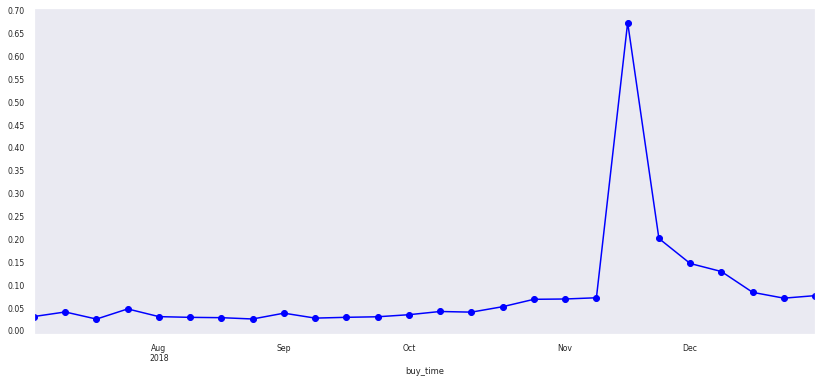

In [203]:
plt.figure(figsize=(14, 6))
df_merged.groupby(['buy_time'])['target'].apply(lambda x: sum(x) / len(x)).plot(color='blue', marker='o')
plt.xticks(df_merged['buy_time'].unique())
plt.yticks(np.arange(0, 0.71, 0.05))
plt.grid()
plt.show()

Как видно, имеется аномальный пик, приходящийся на 19 ноября 2018 года. Создадим маску, так как возможно потребуется исключить эти наблюдения как аутлайера

In [204]:
mask = df_merged['buy_time'] == '2018-11-19'

Посмотрим, какие услуги активнее всего подключались

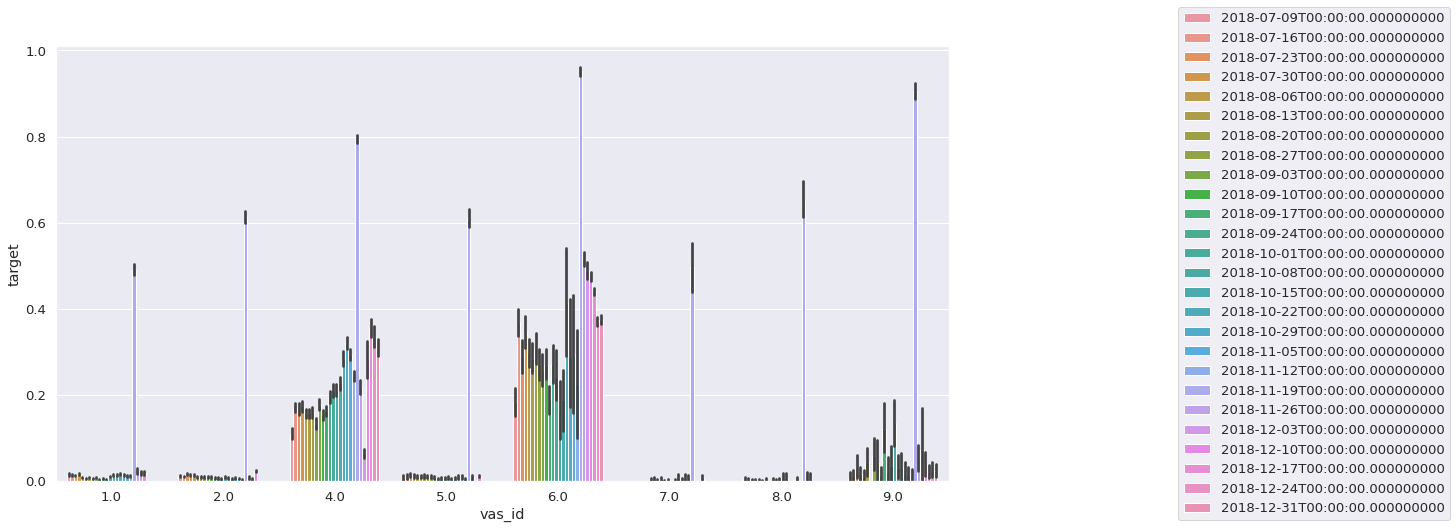

In [205]:
sns.set(font_scale=1.2)
plt.figure(figsize=(16, 8))
g = sns.barplot(x = 'vas_id',
            y = 'target',
            hue='buy_time',
            data = df_merged)#[~mask])
g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

Видим уже отмечаемые пики по подключениям 9 ноября 2018 года.  
Кроме того, можно отметить, что услуги 4 и 6 доминируют по подключениям. Можно использовать для бейзлайна

___

Так как нам неизвестны значения большинства фичей, попробуем посмотреть линейные зависимости, чтобы убрасть столбцы, не  дающие нам дополнительной информации

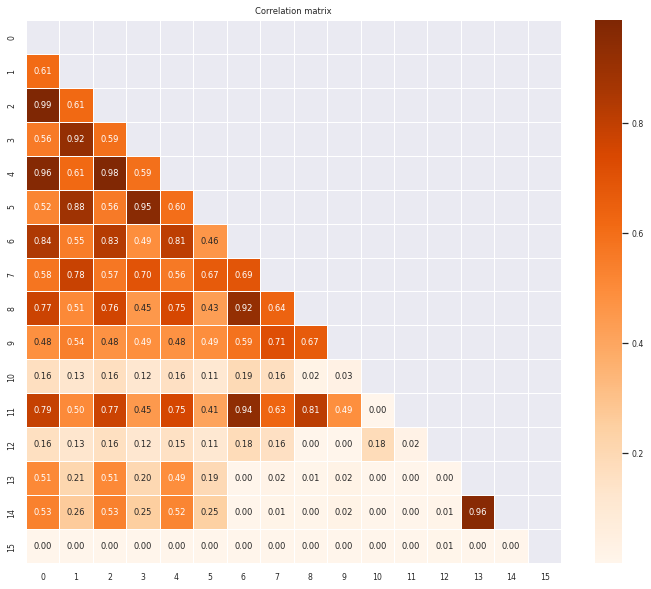

In [206]:
plt.figure(figsize = (12,10))
sns.set(font_scale=0.7)

corr = df_merged.iloc[:, 4:20].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(abs(corr), fmt='.2f', annot=True, linewidths=.5, mask = mask, cmap='Oranges')

plt.title('Correlation matrix')
plt.show()

На сэмпле видно, что у многих столбцов имеется серьезная линейная зависимость. Возможно стоит часть из них убрать

___

Посмотрим на распределение целевой переменной

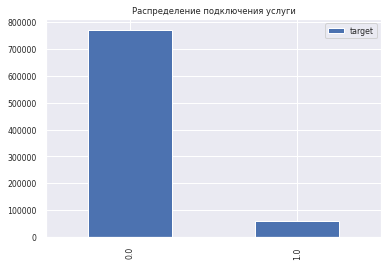

In [207]:
df_merged['target'].value_counts().plot(kind='bar', label='target')
plt.legend()
plt.title('Распределение подключения услуги');

In [208]:
df_merged['target'].value_counts(normalize=True)

0.0    0.927631
1.0    0.072369
Name: target, dtype: float64

Видим, что датасет сильно дисбалансен. Возможно потребуется оверсэмплинг

### Baseline

Построим простейший бейзлайн - если услуга 4 или 6, то пользователь подключит ее, иначе нет.

In [209]:
y_pred = np.where(df_merged['vas_id'].isin([4.0, 6.0]), 1, 0)

In [210]:
f1_score(df_merged['target'].astype(int), y_pred, average='macro')

0.6900037226144814

Исходя из этого, хотим получить скор f1 выше 0.69

___

### Финальная подготовка датасета

Релевантные фичи, найденые борутой

In [211]:
reject_columns = ['194', '195', '201', '252', '26']
green_list = ['id', 'vas_id', 'buy_time', '0', '1', '7', '9', '13', '19', '20', '25', '28', '36', '37', '38', '39', '43', '47', '48', '49', '50', '54', '55', '56', '58', '59', '60', '61', '62', '64', '77', '103', '106', '110', '111', '114', '115', '126', '127', '128', '129', '130', '131', '133', '134', '135', '136', '143', '145', '148', '150', '159', '160', '164', '165', '191', '192', '193', '205', '207', '208', '209', '210', '211', '212', '213', '219', '222', '224', '226', '229', '230', '236', '237', '238', '239', '241', '242', '243', '245', '246', '247', '248', '250']
blue_list = ['132', '196']

In [212]:
X = df_merged.drop(['target'], axis=1)
X = X[green_list]
y = df_merged['target'].astype(int)

In [213]:
X_t = df_merged_test

In [214]:
const_feats = constant_columns(X, thr=0.9)
X.drop(const_feats, axis=1, inplace=True)
drop_correlated(X, threshold=0.8)

X['buy_time'] = X['buy_time'].dt.weekofyear
X_t['buy_time'] = X_t['buy_time'].dt.weekofyear

cat_feats = categorical_columns(X, thr=50)
X[cat_feats] = X[cat_feats].astype('category')

X_t = X_t[X.columns.tolist()]
X_t[cat_feats] = X_t[cat_feats].astype('category')

  0%|          | 0/83 [00:00<?, ?it/s]

Columns before: 84
Columns after: 84


In [215]:
lgb_model = LGBMClassifier(objective='binary',
                          max_depth=8,
                          n_estimators=300,
                          learning_rate=0.05,
                          categorical_column=cat_feats)

**Попробуем, с помощью оверсэмплинга убрать дисбаланс классов**

In [216]:
ros = RandomOverSampler(random_state=SEED)

X_ros, y_ros = ros.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_ros))

Original dataset shape Counter({0: 771467, 1: 60186})
Resample dataset shape Counter({0: 771467, 1: 771467})


In [217]:
lgb_model, y_test, lgb_pred_proba, lgb_f1 = eval_model(lgb_model, X_ros, y_ros)

In [218]:
lgb_f1

0.8892180410447901

Получили подозрительно хороший результат. Проверим на рандомном сэмпле

In [219]:
X_sample = X.sample(10000, random_state=SEED)
y_sample = y[X_sample.index]
y_sample_pred = lgb_model.predict(X_sample)
f1_score(y_sample, y_sample_pred, average='macro')

0.7165511855577795

Видим сильное переобучение. Попробуем обучить модель без оверсэмплинга

In [33]:
lgb_model, y_test, lgb_pred_proba, lgb_f1 = eval_model(lgb_model, X, y)

In [34]:
y_sample_pred = lgb_model.predict(X_sample)
f1_score(y_sample, y_sample_pred, average='macro')

0.6699442084219304

Видим, что несмотря на общую переобученность, первая модель дает лучший результат, рискнем использовать оверсэмплинг.

___

Сравним несколько моделей между собой

In [35]:
log_model = LogisticRegression(random_state=SEED)
rf_model = RandomForestClassifier(random_state=SEED)
gb_model = GradientBoostingClassifier(random_state=SEED)
lgb_model = LGBMClassifier(random_state=SEED, categorical_column=cat_feats, objective='binary')

In [36]:
models = [lgb_model, log_model, rf_model, gb_model]

In [39]:
result = dict()
timing = []
for i, mod in tqdm(enumerate(models)):
    start = time.time()
    result[f"model_{i}"] = eval_model(mod, X_ros, y_ros)
    end = time.time()
    train_time = end - start
    print(train_time)
    timing.append((mod, train_time))

0it [00:00, ?it/s]

19.94716238975525
11.518392562866211
1316.2471697330475
1270.1739230155945


In [50]:
# _, _, _, y_test = train_test_split(X_ros, y_ros, test_size=0.3, random_state=SEED)

lgbm: AUC_PR = 0.930
lgbm: AUC_ROC = 0.941
log_reg: AUC_PR = 0.509
log_reg: AUC_ROC = 0.510
rand_for: AUC_PR = 1.000
rand_for: AUC_ROC = 1.000
gbm: AUC_PR = 0.921
gbm: AUC_ROC = 0.929


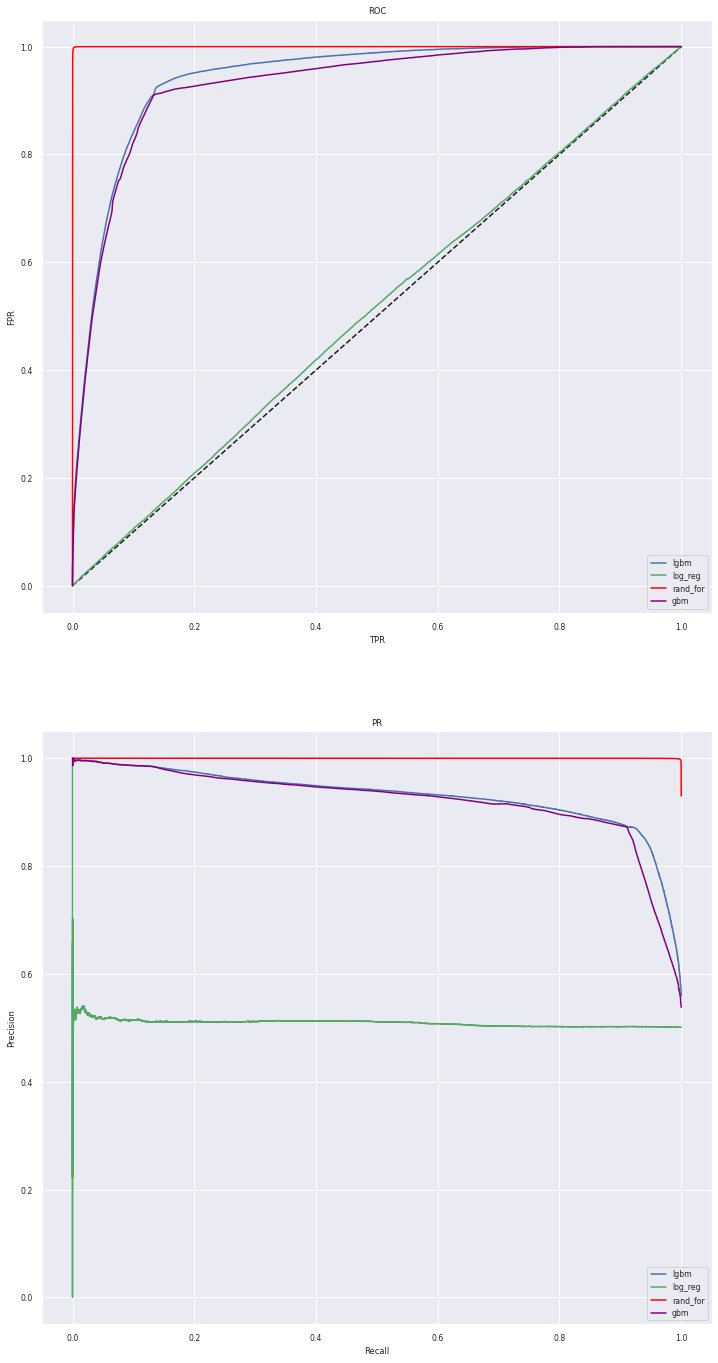

In [55]:
# model comparison
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, result['model_0'][1][:,1])
precision, recall, pr_thresholds = precision_recall_curve(y_test, result['model_0'][1][:,1])
ax1.plot(fpr, tpr, label='lgbm', color='b')
ax2.plot(recall, precision, label='lgbm', color='b')
print("lgbm: AUC_PR = %.3f" % auc(recall, precision))
print("lgbm: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, roc_thresholds = roc_curve(y_test, result['model_1'][1][:,1])
precision, recall, pr_thresholds = precision_recall_curve(y_test, result['model_1'][1][:,1])
ax1.plot(fpr, tpr, label="log_reg", color='g')
ax2.plot(recall, precision, label="log_reg", color='g')
print("log_reg: AUC_PR = %.3f" % auc(recall, precision))
print("log_reg: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, roc_thresholds = roc_curve(y_test, result['model_2'][1][:,1])
precision, recall, pr_thresholds = precision_recall_curve(y_test, result['model_2'][1][:,1])
ax1.plot(fpr, tpr, label="rand_for", color='red')
ax2.plot(recall, precision, label="rand_for", color='red')
print("rand_for: AUC_PR = %.3f" % auc(recall, precision))
print("rand_for: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, roc_thresholds = roc_curve(y_test, result['model_3'][1][:,1])
precision, recall, pr_thresholds = precision_recall_curve(y_test, result['model_3'][1][:,1])
ax1.plot(fpr, tpr, label="gbm", color='purple')
ax2.plot(recall, precision, label="gbm", color='purple')
print("gbm: AUC_PR = %.3f" % auc(recall, precision))
print("gbm: AUC_ROC = %.3f" % auc(fpr, tpr))

ax1.legend(loc="lower right")
ax2.legend(loc="lower right");

In [60]:
sample_list = []
for mod in result:
    sample_list.append(result[mod][0].predict_proba(X_sample))

lgbm: AUC_PR = 0.544
lgbm: AUC_ROC = 0.936
log_reg: AUC_PR = 0.079
log_reg: AUC_ROC = 0.521
rand_for: AUC_PR = 1.000
rand_for: AUC_ROC = 1.000
gbm: AUC_PR = 0.528
gbm: AUC_ROC = 0.924


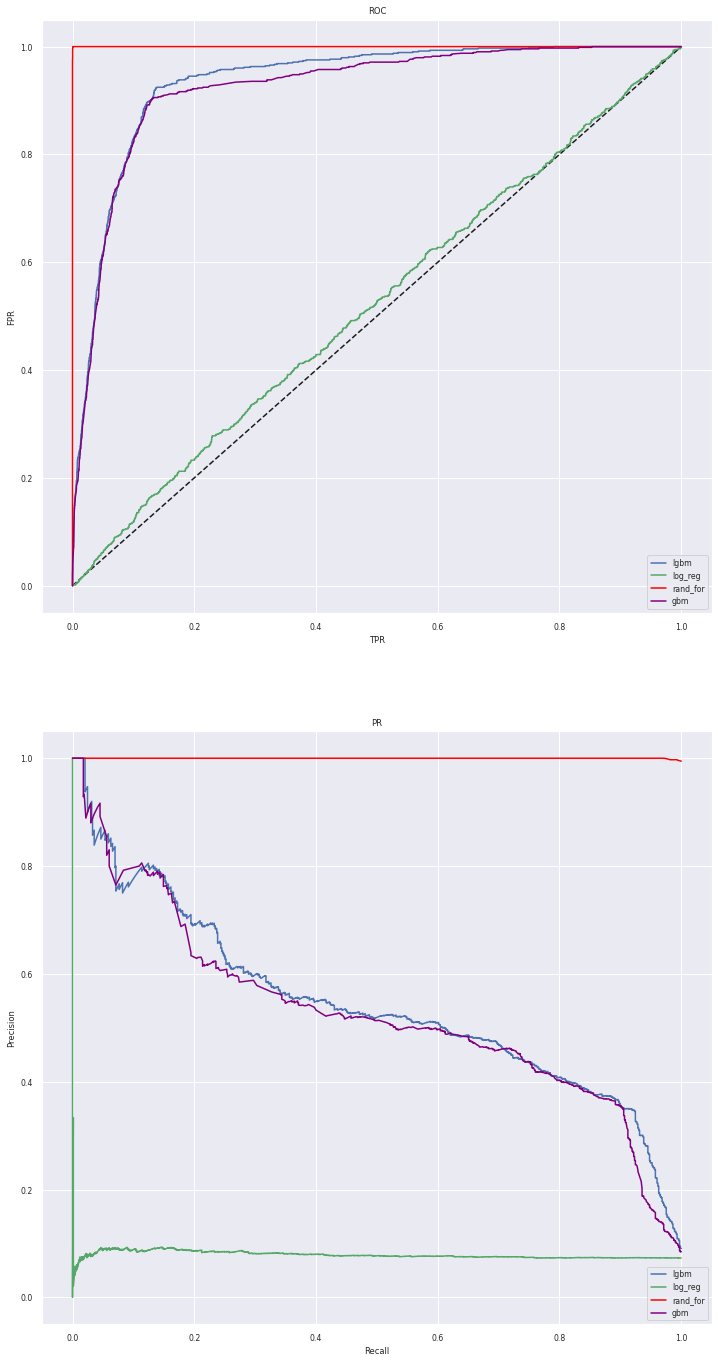

In [65]:
# model comparison
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(24)
f.set_figwidth(12)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_sample, sample_list[0][:,1])
precision, recall, pr_thresholds = precision_recall_curve(y_sample, sample_list[0][:,1])
ax1.plot(fpr, tpr, label='lgbm', color='b')
ax2.plot(recall, precision, label='lgbm', color='b')
print("lgbm: AUC_PR = %.3f" % auc(recall, precision))
print("lgbm: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, roc_thresholds = roc_curve(y_sample, sample_list[1][:,1])
precision, recall, pr_thresholds = precision_recall_curve(y_sample, sample_list[1][:,1])
ax1.plot(fpr, tpr, label="log_reg", color='g')
ax2.plot(recall, precision, label="log_reg", color='g')
print("log_reg: AUC_PR = %.3f" % auc(recall, precision))
print("log_reg: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, roc_thresholds = roc_curve(y_sample, sample_list[2][:,1])
precision, recall, pr_thresholds = precision_recall_curve(y_sample, sample_list[2][:,1])
ax1.plot(fpr, tpr, label="rand_for", color='red')
ax2.plot(recall, precision, label="rand_for", color='red')
print("rand_for: AUC_PR = %.3f" % auc(recall, precision))
print("rand_for: AUC_ROC = %.3f" % auc(fpr, tpr))

fpr, tpr, roc_thresholds = roc_curve(y_sample, sample_list[3][:,1])
precision, recall, pr_thresholds = precision_recall_curve(y_sample, sample_list[3][:,1])
ax1.plot(fpr, tpr, label="gbm", color='purple')
ax2.plot(recall, precision, label="gbm", color='purple')
print("gbm: AUC_PR = %.3f" % auc(recall, precision))
print("gbm: AUC_ROC = %.3f" % auc(fpr, tpr))

ax1.legend(loc="lower right")
ax2.legend(loc="lower right");

In [67]:
f1_score(y_sample, np.where(sample_list[2][:, 1] > 0.5, 1, 0), average='macro')

0.9610152202445132

Отбросим экстремумы в нашем модельном ряду - логистическая регрессия показала себя слишком плохо, случайный лес - слишком хорошо. Точность около единицы маловероятна, модель сильно переобучена  

Градиентные бустинги из sklearn и lightgbm показали себя сравнимо, но по времени работы алгоритма алгоритм от Microsoft явно впереди

In [77]:
pd.DataFrame([tm[1] for tm in timing], columns=['time'],index=['lgbm', 'log_reg', 'rand_for', 'gbm'])

,time
lgbm,19.947162
log_reg,11.518393
rand_for,1316.247170
gbm,1270.173923


In [ ]:
y_test_pred = lgb_model.predict_proba(X_t)[:, 1]

In [227]:
submission = df_test.copy()

In [229]:
submission['target'] = y_test_pred

In [231]:
submission.to_csv('answers_test.csv', index=False)